In [36]:
# Importing necessary libraries for analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import re

# Set plotting font to Segoe UI (font used for the report)
plt.rcParams['font.family'] = 'Segoe UI'

# Load the dataset
df = pd.read_csv("OutliersTreated.csv")

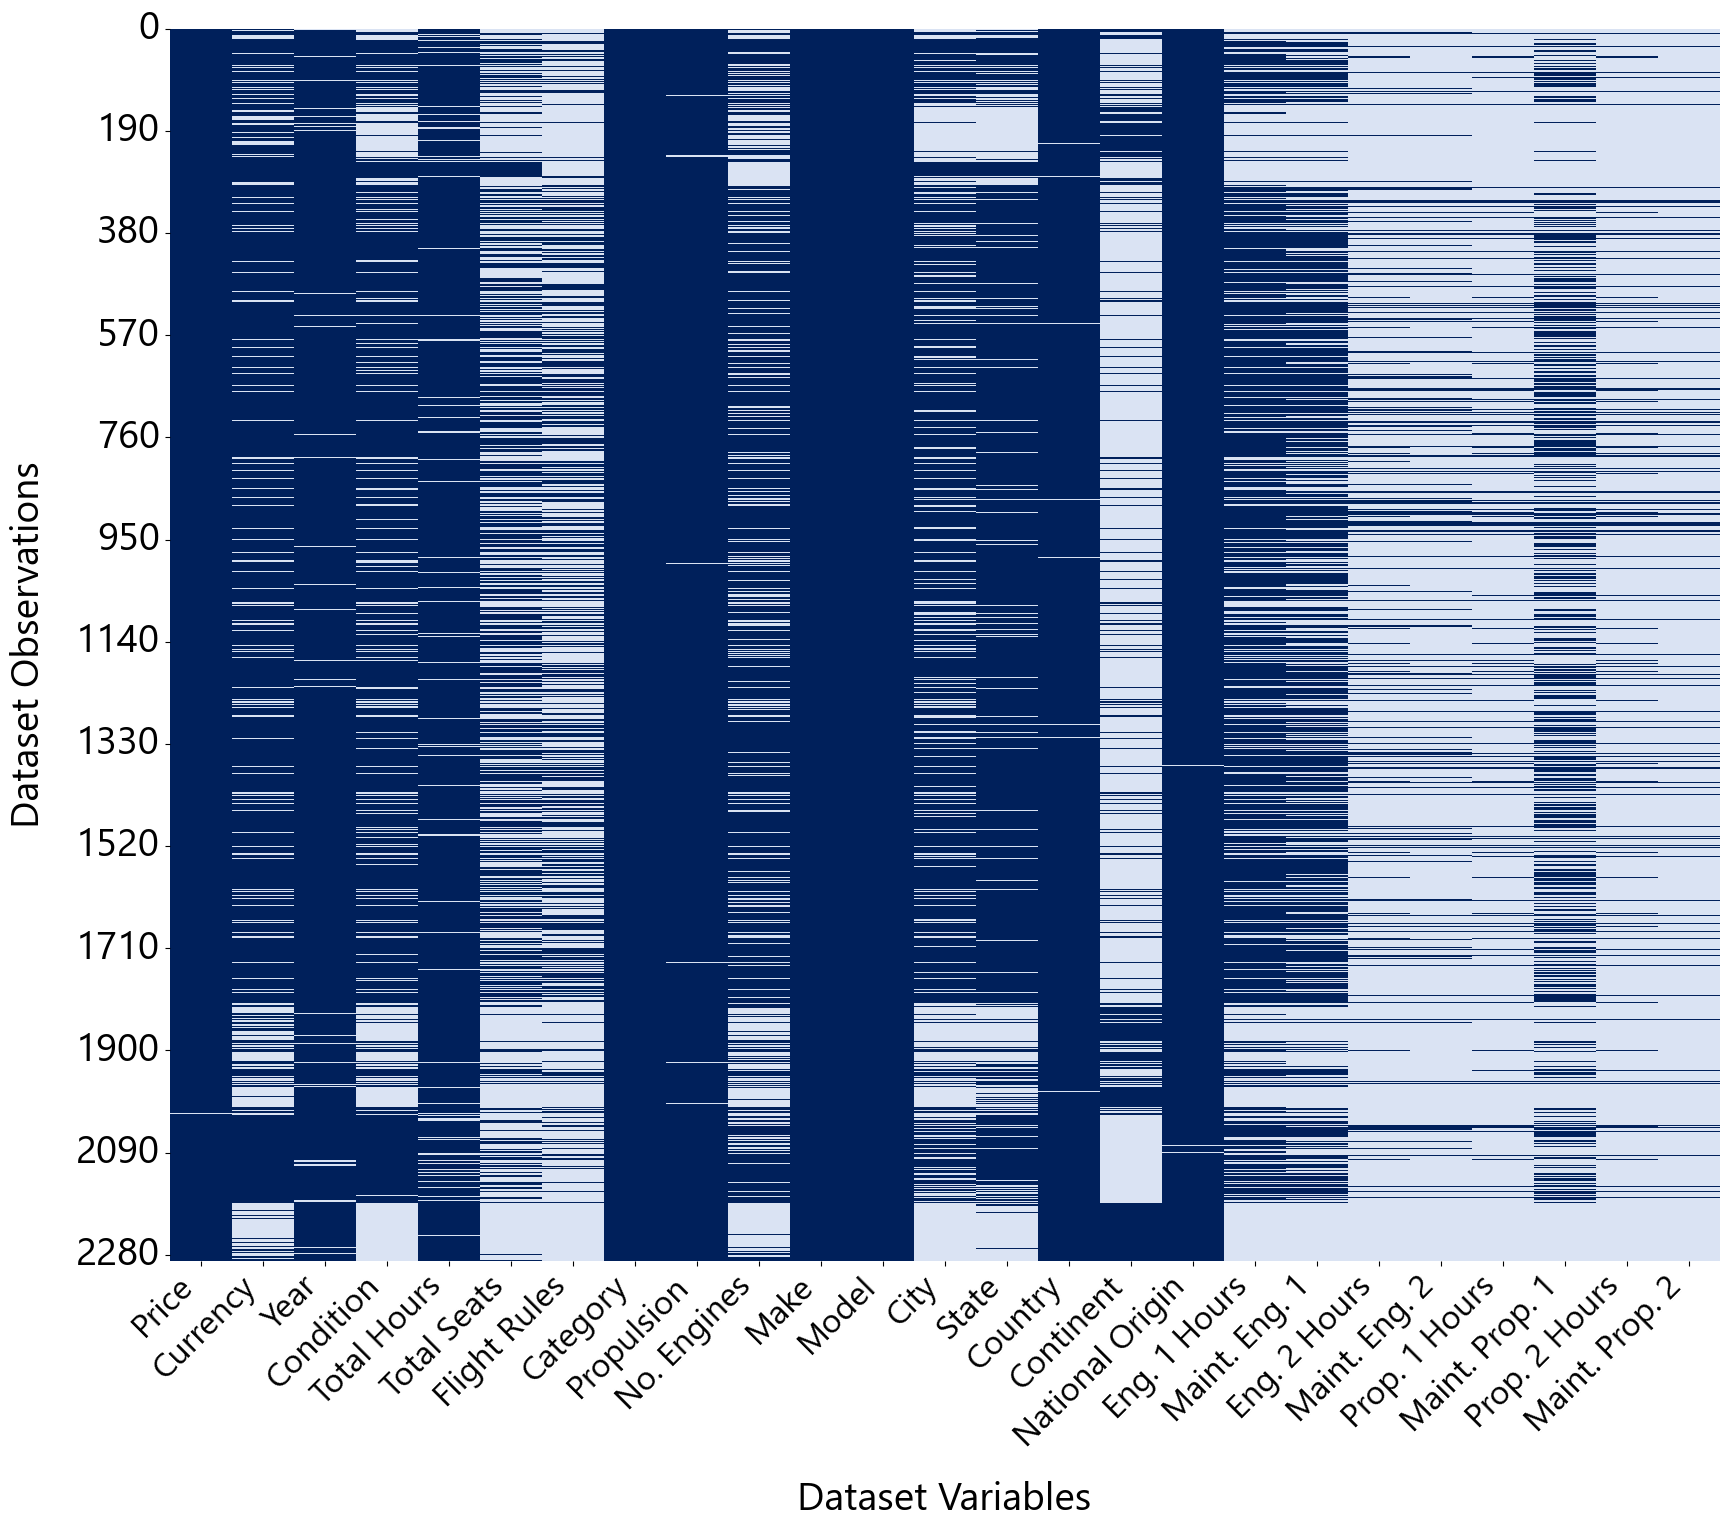

In [ ]:
# Load required parameters
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Replace all missing values (None, float('nan'), etc.) with np.nan (which is NaN)
df = df.where(pd.notnull(df), np.nan)



# Represent a heat map for null values
df_no_text = df.drop(columns=['text']) # For avoiding ploting temporary column 'text'
custom_cmap = ListedColormap(['#DAE3F3', '#00205B'])  # Gray for NaNs, Blue for values
plt.figure(figsize=(20, 16))
sns.heatmap(df_no_text.notnull(), cbar=False, cmap=custom_cmap)
plt.xticks(rotation=45, ha='right') 
y_labels = range(0, len(df), max(1, len(df) // 12))  
plt.yticks(y_labels, [df_no_text.index[i] for i in y_labels], rotation=0) 
plt.xticks(fontsize=24) 
plt.yticks(fontsize=28) 
plt.ylabel('Dataset Observations', fontsize=28, labelpad=20)
plt.xlabel('Dataset Variables', fontsize=28, labelpad=20)
plt.show()

In [38]:
# CONDITION
#This variable includes 3 values and a high values of NaN: 611
#print(df['Condition'].value_counts(dropna=False))


#As the number of NaN is very high and this column corresponds to a categoric variable, a new category 'H' will be created for replacing those NaN.
# Ensure this variable is detected as categoric
df['Condition'] = df['Condition'].astype('category')
# Create new variable
df['Condition'] = df['Condition'].cat.add_categories(['No information'])
df['Condition'] = df['Condition'].fillna('No information')

#Represent results:
#print(df['Condition'].value_counts(dropna=False))

In [39]:
#PRICE 
# Check the number of missing values
nan_count = df['Price'].isna().sum()
#print(nan_count)

# As Price has just one empty cell, this row will be directly deleted (the row is also including many NaN in other columns)
# Show rows with empty Year
# missing_price_rows = df[df['Price'].isna()]
# print(missing_price_rows)

# Delete row with empty Price value
#print(df.shape)
df = df.dropna(subset=['Price'])
#print(df.shape)

In [ ]:
# CURRENCY

# Check the number of missing values: 417
nan_count = df['Currency'].isna().sum()
# print(nan_count)

# NaN will be completed from the currency specified into the Price column and that have been saved into temporary column 'text'

# Function to assign currency according to the text before the numbers in the Price columns: 
def assign_currency(row):
    if pd.isna(row['Currency']):
        # Check that 'text' is not NaN and is a string
        if isinstance(row['text'], str):  # Ensure 'text' is a string
            if 'Price: USD $' in row['text']:
                return 'USD'
            elif 'Price: â,¬' in row['text']:
                return 'EUR'
            elif 'Price: Â£' in row['text']:
                return 'GBP'
            elif '$' in row['text']:
                return 'USD'  
    return row['Currency']  # Return the current value if the condition is not met


# Apply the function to update 'Currency'
df['Currency'] = df.apply(assign_currency, axis=1)
#print(df['Currency'].value_counts(dropna=False))


# With this method, NaN values are reduced to 6 cells, as now the number of missing values is small, a KNN method will be implemented based on Country and National Origin

# Convert 'Country' and 'National Origin' to numeric values
encoder = LabelEncoder()
df['Country_encoded'] = encoder.fit_transform(df['Country'].fillna('Missing'))  # Temporarily replace NaN
df['Origin_encoded'] = encoder.fit_transform(df['National Origin'].fillna('Missing'))  # Temporarily replace NaN

# Filter rows where 'Currency' is not NaN to train the model
df_train = df[df['Currency'].notna()]

# Define X and y for training
X_train = df_train[['Country_encoded', 'Origin_encoded']]
y_train = df_train['Currency']

# Filter rows with NaN in 'Currency' for prediction
df_predict = df[df['Currency'].isna()]
X_predict = df_predict[['Country_encoded', 'Origin_encoded']]

# Train the KNN model (k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict missing values for 'Currency'
predicted_currency = knn.predict(X_predict)

# Assign the predicted values to the 'Currency' column in the corresponding rows
df.loc[df['Currency'].isna(), 'Currency'] = predicted_currency

# Check the final values of 'Currency'
#print(df['Currency'].value_counts(dropna=False))

# If you want to see the first rows of the DataFrame with imputed values
#print(df.head())

# Check accuracy
# Calculate the accuracy of the model using the training rows
# Make predictions on the training rows
y_train_pred = knn.predict(X_train)
# Calculate the accuracy
accuracy = accuracy_score(y_train, y_train_pred)
#print(f"Model Accuracy: {accuracy:.4f}")

# The accuracy of the model was 0.9716

c:\Users\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or 

In [41]:
# COLUMNS DERIVED FROM INITIAL CATEGORY

# CATEGORY - No missing values
# Check the number of missing values: 0
nan_count = df['Category'].isna().sum()
#print(nan_count)



# PROPULSION
# Check the number of missing values: 13 - Just missing values from 'Military/Classic/Vintage', 'Ultralight' and 'Gliders/Sailplanes' Category
nan_count = df['Propulsion'].isna().sum()
#print(nan_count)

# For rows with missing values for Propulsion show model value to manually complete Propulsion 
filtered_models = df[df['Category'].isin(['Military/Classic/Vintage', 'Ultralight', 'Motor Gliders/Sailplanes'])][['Category','Model']]
# print(filtered_models)

# All Military/Classic/Vintage correspond to Piston Engines with only one engine, with exception of ME 262 which has two turbojets
df.loc[df['Category'].isin(['Military/Classic/Vintage']), 'Propulsion'] = 'Piston Engine' 
df.loc[df['Category'].isin(['Military/Classic/Vintage']), 'No. Engines'] = 1 
df.loc[df['Model'] == 'ME 262', ['Propulsion']] = 'Turbojet'
df.loc[df['Model'] == 'ME 262', ['No. Engines']] = 2

# All Ultralight correspond to Piston Engines with only one engine
df.loc[df['Category'].isin(['Ultralight']), 'Propulsion'] = 'Piston Engine' 
df.loc[df['Category'].isin(['Ultralight']), 'No. Engines'] = 1 

# All Gliders/Sailplanes correspond to Piston Engines with only one engine
df.loc[df['Category'].isin(['Motor Gliders/Sailplanes']), 'Propulsion'] = 'Piston Engine' 
df.loc[df['Category'].isin(['Motor Gliders/Sailplanes']), 'No. Engines'] = 1 

# Check the number of missing values after the method: 0
nan_count = df['Propulsion'].isna().sum()
#print(nan_count)



# NO. ENGINES
# Check the number of missing values: 693
nan_count = df['No. Engines'].isna().sum()
#print(nan_count)

# No. of Engines for Turbofan, Turboprop, Turboshaft can not be known as the number of rows is large
# So it will be assumed that for those Categories if Eng. 1 Hours is not null but Eng. 2 Hours is, then 
# the number of engines will be 1. As well, if both Eng. Hours are filled (not empty), then it will be assumed
# that the number of engines will be 2.
df.loc[
    (df['Propulsion'].isin(['Turboshaft', 'Turboprop', 'Turbofan'])) & 
    (df['Eng. 1 Hours'].notna()) & 
    (df['Eng. 2 Hours'].isna()), 
    'No. Engines'
] = 1

df.loc[
    (df['Propulsion'].isin(['Turboshaft', 'Turboprop', 'Turbofan'])) & 
    (df['Eng. 1 Hours'].notna()) & 
    (df['Eng. 2 Hours'].notna()), 
    'No. Engines'
] = 2

# filtered_df = df.loc[df['Propulsion'].isin(['Turboshaft', 'Turboprop', 'Turbofan']), ['Propulsion', 'Eng. 1 Hours', 'Eng. 2 Hours', 'No. Engines']]
# print(filtered_df)

# For verification purposes, it will be check that there is not exists any model with different number of engine,
# if any, they will be manually searched and adjusted accordingly.

# Group by 'Model' and check if there is more than one unique value in 'No. Engines'
models_with_different_engines = df.groupby('Model')['No. Engines'].nunique() > 1
# Filter the models with discrepancies
models_with_discrepancies = models_with_different_engines[models_with_different_engines].index
# Display the rows corresponding to those models
filtered_df = df[df['Model'].isin(models_with_discrepancies)]
# print(filtered_df['Model'])

# Several rows with the same value in model present different No. Engines, these values will be manually ammended: King Air 350I, King Air C90B, P210 Silver Eagle
# L-39C Albatros and King Air C90
df.loc[df['Model'] == 'King Air 350I', ['No. Engines']] = 2
df.loc[df['Model'] == 'King Air C90B', ['No. Engines']] = 2
df.loc[df['Model'] == 'P210 Silver Eagle', ['No. Engines']] = 1
df.loc[df['Model'] == 'L-39C Albatros', ['No. Engines']] = 2
df.loc[df['Model'] == 'King Air C90', ['No. Engines']] = 2

# Number of missing values for No. Engines after the method: 562
nan_count = df['No. Engines'].isna().sum()
#print(nan_count)


# Finally, missing values in turbofan, turboprop and turboshaft will be filled based on the most repeated value for the corresponding Propulsion type:

# Filter rows where Propulsion = Turbofan
turbofan_data = df[(df['Propulsion'] == 'Turbofan') & (df['No. Engines'].notna())]
# Calculate mode of No. Engines column for these rows
mode_value_turbofan = turbofan_data['No. Engines'].mode()[0]
#print(mode_value_turbofan)
# Compute the proportion of Turbofan rows equal to the mode: 0.77
proportion_turbofan = (turbofan_data['No. Engines'] == mode_value_turbofan).mean()
#print(proportion_turbofan)
df.loc[(df['Propulsion'] == 'Turbofan') & (df['No. Engines'].isna()), 'No. Engines'] = 2


# Filter rows where Propulsion = Turboprop
turboprop_data = df[(df['Propulsion'] == 'Turboprop') & (df['No. Engines'].notna())]
# Calculate mode of No. Engines column for these rows
mode_value_turboprop = turboprop_data['No. Engines'].mode()[0]
#print(mode_value_turboprop)
# Compute the proportion of Turboprop rows equal to the mode: 0.52
proportion_turboprop = (turboprop_data['No. Engines'] == mode_value_turboprop).mean()
#print(proportion_turboprop)
df.loc[(df['Propulsion'] == 'Turboprop') & (df['No. Engines'].isna()), 'No. Engines'] = 2


# Filter rows where Propulsion = Turboshaft
turboshaft_data = df[(df['Propulsion'] == 'Turboshaft') & (df['No. Engines'].notna())]
# Calculate mode of No. Engines column for these rows
mode_value_turboshaft = turboshaft_data['No. Engines'].mode()[0]
#print(mode_value_turboshaft)
# Compute the proportion of Turboshaft rows equal to the mode: 0.91
proportion_turboshaft = (turboshaft_data['No. Engines'] == mode_value_turboshaft).mean()
#print(proportion_turboshaft)
df.loc[(df['Propulsion'] == 'Turboshaft') & (df['No. Engines'].isna()), 'No. Engines'] = 1


# Filter rows where Propulsion = Piston Engine & Category is Rotorcraft
heli_data = df[(df['Propulsion'] == 'Piston Engine') & (df['Category'] == 'Rotorcraft') & (df['No. Engines'].isna()) ]
# print(heli_data)
#print(df['Category'].value_counts(dropna=False))
# # Calculate mode of No. Engines column for these rows
#mode_value_heli = heli_data['No. Engines'].mode()[0]
#print(mode_value_heli)
# # Compute the proportion of Turboshaft rows equal to the mode: 0.9091
# proportion_heli = (heli_data['No. Engines'] == mode_value_heli).mean()
#print(proportion_heli)
df.loc[(df['Propulsion'] == 'Piston Engine') & (df['Category'] == 'Rotorcraft'), ['No. Engines']] = 1

# Number of missing values for No. Engines after the method: 0
nan_count = df['No. Engines'].isna().sum()
#print(nan_count)

In [42]:
# YEAR

# Check the number of missing values: 62
nan_count = df['Year'].isna().sum()
#print(nan_count)

# Complete missing values using the mean of the variable
mean_year = round(df['Year'].mean())
#print(mean_year)
# Check in how many cells the mean was already present: 15
count_1987 = (df['Year'] == mean_year).sum()
#print(f"Number of rows with Year = 1987: {count_1987}")
# Complete missing values with mean
df['Year'] = df['Year'].fillna(mean_year)

nan_count = df['Year'].isna().sum()
#print(nan_count)

In [43]:
# MAKE - No missing values

# Check the number of missing values: 0
nan_count = df['Make'].isna().sum()
# print(nan_count)

In [44]:
# MODEL - No missing values

# Check the number of missing values: 0
nan_count = df['Model'].isna().sum()
# print(nan_count)

In [45]:
# TOTAL HOURS
# Check the number of missing values: 116
nan_count = df['Total Hours'].isna().sum()
#print(nan_count)

# Complete missing values using the mean of the variable
mean_hours = df['Total Hours'].mean()
#print(mean_hours)
# Check in how many cells the mean was already present: 0
count_mean = (df['Total Hours'] == mean_hours).sum()
#print(f"Number of rows with Total Hours = 3939.38: {count_mean}")
# Complete missing values with mean
df['Total Hours'] = df['Total Hours'].fillna(mean_hours)

nan_count = df['Total Hours'].isna().sum()
#print(nan_count)

In [46]:
# TOTAL SEATS
# Check the number of missing values: 1188
nan_count = df['Total Seats'].isna().sum()
#print(nan_count)


def fill_missing_seats(df):
    # Create a mapping of models to seats where 'Total Seats' is not null, using the most frequent value of seats if different values are associated to a same model
    model_to_seats = (
    df.loc[df['Total Seats'].notna()]
    .groupby('Model')['Total Seats']
    .agg(lambda x: x.value_counts().idxmax())  # Most frequent value
    .to_dict()
)
    
    # Function to replace missing seats with the mapped value from model_to_seats
    def replace_seats(row):
        if pd.isna(row['Total Seats']) and row['Model'] in model_to_seats:
            return model_to_seats[row['Model']]
        return row['Total Seats']
    
    # Apply the function to the DataFrame
    df['Total Seats'] = df.apply(replace_seats, axis=1)
    return df

df = fill_missing_seats(df)

# Missing values after this method: 655
nan_count = df['Total Seats'].isna().sum()
#print(nan_count)


# Complete missing values using the mean of the variable
mean_seats = df['Total Seats'].mean()
#print(mean_seats)
# Check in how many cells the mean was already present: 0
count_mean = (df['Total Seats'] == round(mean_seats)).sum()
#print(f"Number of rows with Total Hours = 4.47: {count_mean}")
# Complete missing values with mean
df['Total Seats'] = df['Total Seats'].fillna(round(mean_seats))

#print(df['Total Seats'].value_counts(dropna=False))



# # Complete missing values using the mean of the variable
# mean_seats = round(df['Total Seats'].mean())
# print(mean_seats)
# # Check in how many cells the mean was already present: 0
# count_mean = (df['Total Seats'] == mean_seats).sum()
# print(f"Number of rows with Total Seats = 12073: {count_mean}")
# # Complete missing values with mean
# df['Total Seats'] = df['Total Seats'].fillna(mean_seats)



# missing_seats_rows = df[df['Total Seats'].isna()]

# # Replace missing values explicitly with np.nan
# df.replace({None: np.nan, 'NA': np.nan}, inplace=True)
# # Encode categorical variables (Category, Propulsion, Make, Model)
# encoder = LabelEncoder()
# for col in ['Category', 'Propulsion', 'Make', 'Model']:
#     df[col] = encoder.fit_transform(df[col].astype(str))

# # Separate known data (Total Seats not missing)
# known_data = df[df['Total Seats'].notna()]
# unknown_data = df[df['Total Seats'].isna()]

# # Train-test split within known data
# train, test = train_test_split(known_data, test_size=0.3, random_state=42)

# # Prepare data for imputation
# imputer = IterativeImputer(max_iter=10, random_state=0)

# # Train imputer only on the training set
# imputer.fit(train[['Category', 'Propulsion', 'Make', 'Model', 'Total Seats']])

# # Impute missing values in the test set
# test_imputed = test.copy()
# test_imputed['Total Seats'] = imputer.transform(test[['Category', 'Propulsion', 'Make', 'Model', 'Total Seats']])[:, -1]

# # Round imputed values to integers
# test_imputed['Total Seats'] = test_imputed['Total Seats'].round().astype(int)

# # Compare imputed vs actual values
# accuracy = accuracy_score(test['Total Seats'].astype(int), test_imputed['Total Seats'].astype(int))
# print(f"Model Accuracy: {accuracy:.4f}")

# # After imputation, identify rows where 'Total Seats' was filled
# predicted_seats_rows = df.loc[missing_seats_rows.index]

# # Display rows where 'Total Seats' was predicted
# print(predicted_seats_rows[['Total Seats', 'Category', 'Propulsion', 'Make', 'Model']])


nan_count = df['Total Seats'].isna().sum()
#print(nan_count)

In [47]:
# FLIGHT RULES
# Check the number of missing values: 1499
nan_count = df['Flight Rules'].isna().sum()
#print(nan_count)

def fill_missing_rules(df):
    # Create a mapping of models to rules where 'Fligh Rules' is not null
    model_to_rules = df.loc[df['Flight Rules'].notna(), ['Model', 'Flight Rules']].set_index('Model')['Flight Rules'].to_dict()
    
    # Function to replace missing flight rules with the mapped value from model_to_rules
    def replace_rules(row):
        if pd.isna(row['Flight Rules']) and row['Model'] in model_to_rules:
            return model_to_rules[row['Model']]
        return row['Flight Rules']
    
    # Apply the function to the DataFrame
    df['Flight Rules'] = df.apply(replace_rules, axis=1)
    return df
df = fill_missing_rules(df)

# With this method the number of missing values has been reduced to 786
nan_count = df['Flight Rules'].isna().sum()
#print(nan_count)


#As the number of NaN is very high and this column corresponds to a categoric variable, a new category 'H' will be created for replacing those NaN.
df['Flight Rules'] = df['Flight Rules'].astype('category')
#print(df['Flight Rules'].dtype)
df['Flight Rules'] = df['Flight Rules'].cat.add_categories(['No information'])
df['Flight Rules'] = df['Flight Rules'].fillna('No information')

#Represent results:
#print(df['Flight Rules'].value_counts(dropna=False))

In [48]:
# COLUMNS DERIVED FROM LOCATION

# CITY - This is the lowest value for location so it can not be derived from the rest of the columns, column to be deleted at the end
# Check the number of missing values: 762
nan_count = df['City'].isna().sum()
#print(nan_count)

# Correct a found misleading value
df.loc[df['City'] == 'Empuriabrava', ['Country']] = 'Spain'


# STATE
# Check the number of missing values: 519
nan_count = df['State'].isna().sum()
#print(nan_count)

# State is a value that may not exist for all of the Locations, let see for which countries, State is provided
# The only countries for which can subdive into states are ['United States', 'Canada', 'Mexico', 'Australia', 'India', 'Brazil', 'Germany', 'Argentina', 'Nigeria', 'United Arab Emirates', 'Pakistan', 'Malaysia', 'Switzerland', 'Venezuela']
# but most of States are provided for United States, having also 86 entries with Canada. 3 for Mexico and other 3 for Australia. Let's just keep States from United States and Canada
valid_countries = ['United States']
# Set 'State' to 'N/A' where 'Country' is not in the list of valid countries
df.loc[~df['Country'].isin(valid_countries), 'State'] = 'N/A'

# Check the number of missing values: 58
nan_count = df['State'].isna().sum()
#print(nan_count)


# Now, still missing values in the "State" column will be filled based on matching "City" values if found
# Function to fill missing values in 'State' based on matching 'City'
def fill_missing_states(df):
    # Create a mapping of cities to states where 'State' is not null
    city_to_state = df.loc[df['State'].notna(), ['City', 'State']].set_index('City')['State'].to_dict()
    # Function to replace missing state with the mapped value from city_to_state
    def replace_state(row):
        if pd.isna(row['State']) and row['City'] in city_to_state:
            return city_to_state[row['City']]
        return row['State']
    # Apply the function to the DataFrame
    df['State'] = df.apply(replace_state, axis=1)
    return df

# Apply the function
df = fill_missing_states(df)

# Check the number of missing values after the method: 12
nan_count = df['State'].isna().sum()
#print(nan_count)

# The remaining missing values will be ammend manually using their values into City column:
nan_states = df.loc[df['State'].isna(), ['City', 'State', 'Country']]
#print(nan_states)

df.loc[df['City'] == 'South Carolina', ['State']] = 'SC'
df.loc[df['City'] == 'Gold Coast', ['State']] = 'IL'
df.loc[df['City'] == 'Gold Coast', ['State']] = 'FL'
df.loc[df['City'] == 'Culver', ['State']] = 'CA'
df.loc[df['City'] == 'KMTH', ['State']] = 'FL'
df.loc[df['City'] == 'KFMY', ['State']] = 'FL'
df.loc[df['City'] == 'Sugar Grove', ['State']] = 'IL'
df.loc[df['City'] == 'Wadmalaw', ['State']] = 'SC'
df.loc[df['City'] == 'Elmira', ['State']] = 'NY'

# Check the number of missing values after the method: 0
nan_count = df['State'].isna().sum()
#print(nan_count)




# COUNTRY

# Check the number of missing values: 17
nan_count = df['Country'].isna().sum()
#print(nan_count)

# Search missing values into matching State and City. As no NaN values found after completing missing values using State column,
# City column is not necesssary

# Function to fill missing values in 'Country' based on matching 'State'
def fill_missing_countries(df):
    # Create a mapping of states to countries where 'Country' is not null
    state_to_country = df.loc[df['Country'].notna(), ['State', 'Country']].set_index('State')['Country'].to_dict()
    
    # Function to replace missing country with the mapped value from state_to_country
    def replace_country(row):
        if pd.isna(row['Country']) and row['State'] in state_to_country:
            return state_to_country[row['State']]
        return row['Country']
    
    # Apply the function to the DataFrame
    df['Country'] = df.apply(replace_country, axis=1)
    return df

df = fill_missing_countries(df)

# Check the number of missing values after the method: 0
nan_count = df['Country'].isna().sum()
#print(nan_count)




# CONTINENT 
# Check the number of missing values: 1788
nan_count = df['Continent'].isna().sum()
#print(nan_count)

# Same as in previous columns, continent is filled based in other matching Country values
# Function to fill missing values in 'Continent' based on matching 'Country'
def fill_missing_continents(df):
    # Create a mapping of countries to continents where 'Continent' is not null
    country_to_continent = df.loc[df['Continent'].notna(), ['Country', 'Continent']].set_index('Country')['Continent'].to_dict()
    
    # Function to replace missing continent with the mapped value from country_to_continent
    def replace_continent(row):
        if pd.isna(row['Continent']) and row['Country'] in country_to_continent:
            return country_to_continent[row['Country']]
        return row['Continent']
    
    # Apply the function to the DataFrame
    df['Continent'] = df.apply(replace_continent, axis=1)
    return df
df = fill_missing_continents(df)

# Check the number of missing values after the method: 4
nan_count = df['Continent'].isna().sum()
#print(nan_count)

# Still 4 missing values - Having Kenya, Uruguay, Argentina and Serbia as country Values
# Extract rows where 'Continent' is NaN
rows_with_nan = df[df['Continent'].isna()]
# Display the extracted rows
#print(rows_with_nan)
df.loc[df['Country'] == 'Kenya', ['Continent']] = 'Africa'
df.loc[df['Country'] == 'Uruguay', ['Continent']] = 'South America'
df.loc[df['Country'] == 'Argentina', ['Continent']] = 'South America'
df.loc[df['Country'] == 'Serbia', ['Continent']] = 'Europe'


# Check the number of missing values after the method: 4
nan_count = df['Continent'].isna().sum()
#print(nan_count)

In [49]:
# ENGINE 1 HOURS, ENGINE 2 HOURS, PROPELLER 1 HOURS, PROPELLER 2 HOURS

# Determine if these fields should have a value or be set as N/A

# Firstly No.engines = 1 will have Engine 2 Hours as N/A and it can be assumed that Prop 2 will be N/A as well
df.loc[df['No. Engines'] == 1, ['Eng. 2 Hours', 'Prop. 2 Hours']] = 0
# If Propulsion = Turbofan, there is no propellers
df.loc[df['Propulsion'] == 'Turbofan', ['Prop. 1 Hours', 'Prop. 2 Hours']] = 0  # Cirrus Vision SF50 has propellers listed but actually has a turbofan engine
df.loc[df['Propulsion'] == 'Turbojet', ['Prop. 1 Hours', 'Prop. 2 Hours']] = 0

filtered_df = df.loc[df['Propulsion'] == 'Turboprop', ['Propulsion', 'Eng. 2 Hours', 'Prop. 2 Hours']]
#print(filtered_df)

# If the value is N/A, then Maintenance Type columns should also be N/A
df.loc[df['Eng. 1 Hours'] == 0, 'Maint. Eng. 1'] = 'N/A'
df.loc[df['Eng. 2 Hours'] == 0, 'Maint. Eng. 2'] = 'N/A'
df.loc[df['Prop. 1 Hours'] == 0,'Maint. Prop. 1'] = 'N/A'
df.loc[df['Prop. 2 Hours'] == 0,'Maint. Prop. 2'] = 'N/A'

In [50]:
# NATIONAL ORIGIN

# Check the number of missing values: 6
nan_count = df['National Origin'].isna().sum()
#print(nan_count)


# By plotting the rows in which these NaN for the National Origin column appear, it can be observed that the value can be assigned to be the same as Country
# as they are replicas produced which manufacturer is based on the country it is or they are homebuilt.
df_filtered_nan = df[df['National Origin'].isna()]
# print(df_filtered_nan)
# Assigning the country value to national origin
df['National Origin'] = df['National Origin'].fillna(df['Country'])

# Check the number of missing values after the method: 0
nan_count = df['National Origin'].isna().sum()
#print(nan_count)

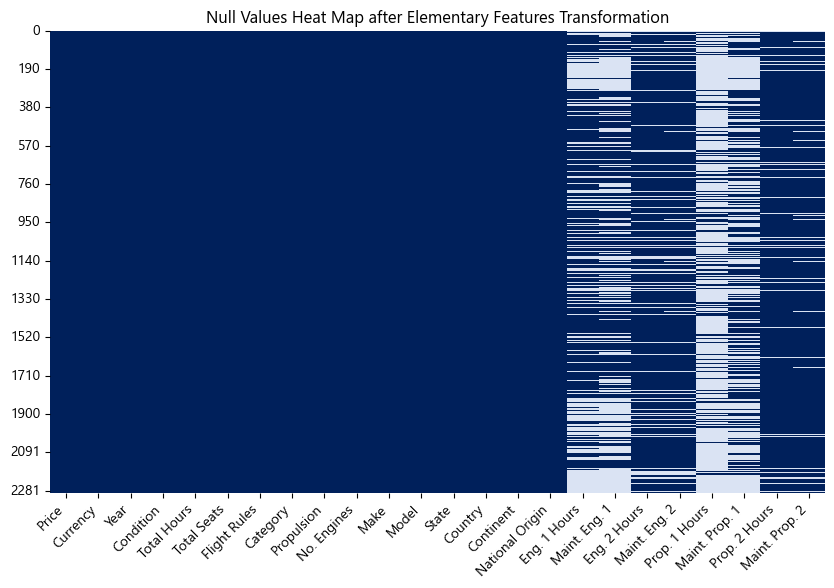

In [51]:
# Remove no longer necessary columns 
# print(df.columns)
df.drop(columns = ['City', 'Country_encoded', 'Origin_encoded'], axis=1, inplace=True)
# print(df.columns)


# Represent a heat map for null values
df_no_text = df.drop(columns=['text']) # For avoiding ploting temporary column 'text'
custom_cmap = ListedColormap(['#DAE3F3', '#00205B'])  # Gray for NaNs, Blue for values
plt.figure(figsize=(10, 6))
sns.heatmap(df_no_text.notnull(), cbar=False, cmap=custom_cmap)
plt.title("Null Values Heat Map after Elementary Features Transformation")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees, align to the right
y_labels = range(0, len(df), max(1, len(df) // 12))  # Display ~10 evenly spaced labels
plt.yticks(y_labels, [df_no_text.index[i] for i in y_labels], rotation=0)  # Keep y-axis labels horizontal
plt.show()

In [52]:
# Save the Missing Data Treated DataFrame into a CSV file
df.to_csv(r'C:\Users\Ángela Martín Milán\Desktop\TFM\MissingDataTreated.csv', index=False)